# 머신 러닝 교과서 2판

# Chapter 15: Classifying Images with Deep Convolutional Neural Networks (Part 2/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt

## Gender classification from face images using CNN


### Loading the CelebA dataset

In [2]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare(download_dir='~/github/tensorflow_datasets/downloads')
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('훈련 데이터셋:  {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))
print('테스트 데이터셋:   {}'.format(count_items(celeba_test)))

dict_keys(['test', 'train', 'validation'])
훈련 데이터셋:  162770
검증 데이터셋: 19867
테스트 데이터셋:   19962


In [3]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('훈련 데이터셋:  {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))

훈련 데이터셋:  16000
검증 데이터셋: 1000


### Image transformation and data augmentation

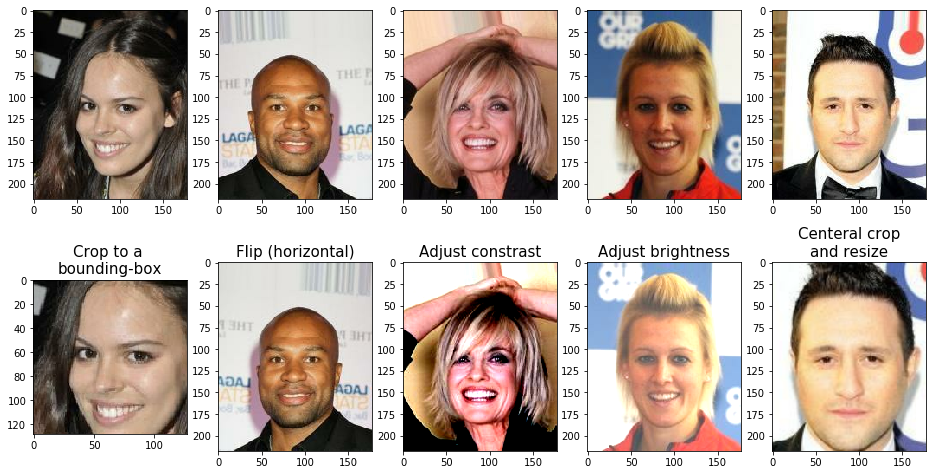

In [4]:
## take 5 examples:
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

plt.savefig('images/15_14.png', dpi=300)
plt.show()

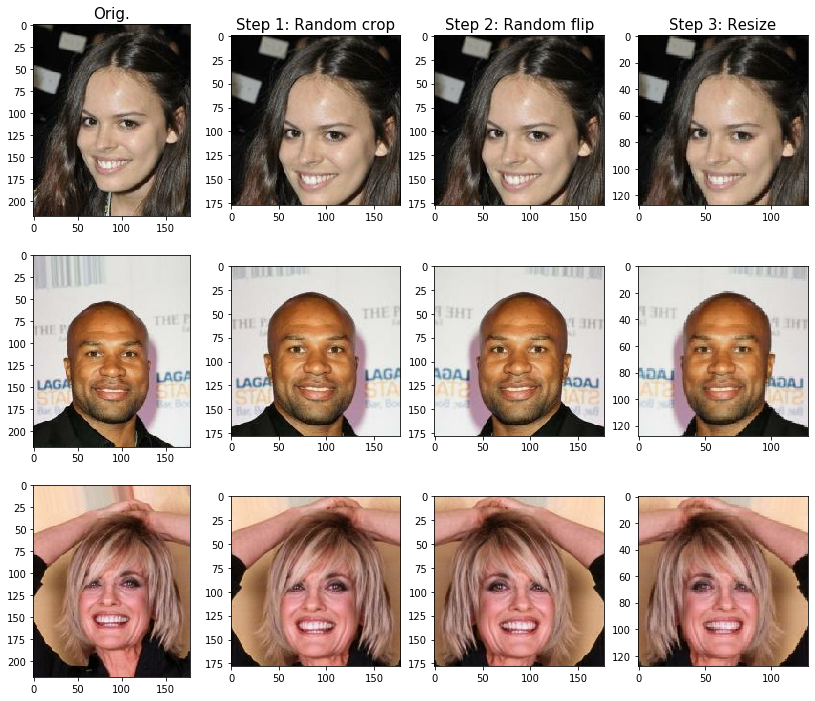

In [5]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

plt.savefig('images/15_15.png', dpi=300)
plt.show()

In [6]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

## testing:
#item = next(iter(celeba_train))
#preprocess(item, mode='train')

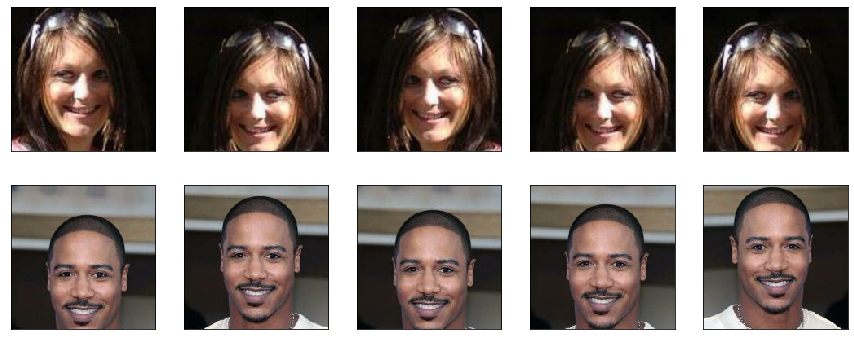

In [7]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)

ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
plt.savefig('images/15_16.png', dpi=300)
plt.show()

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

500.0


### Training a CNN gender classifier

* **Global Average Pooling**

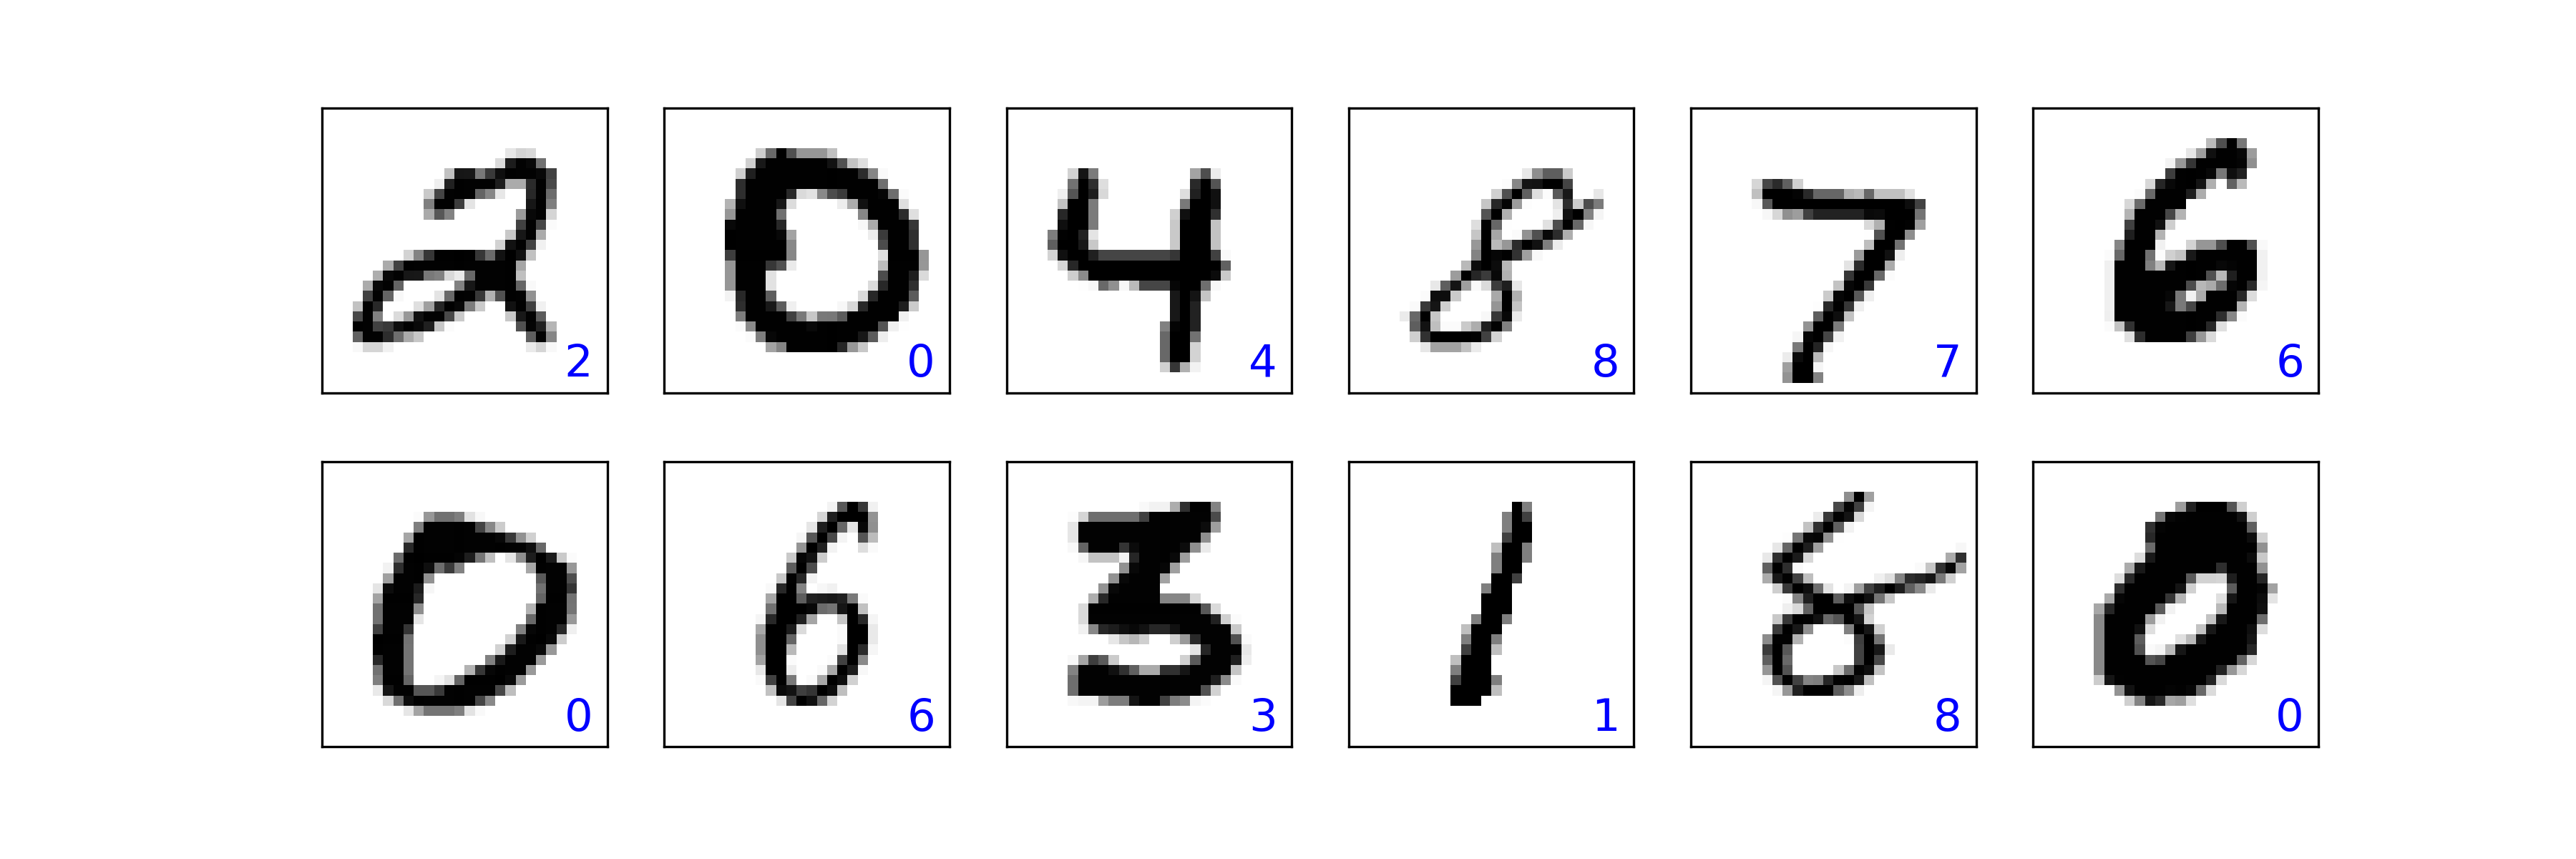

In [9]:
Image(filename='images/15_13.png', width=800)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
])

In [11]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [12]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [13]:
model.add(tf.keras.layers.Dense(1, activation=None))

In [14]:
tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 0.6331 - accuracy: 0.6175 - val_loss: 0.5497 - val_accuracy: 0.6710
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5407 - accuracy: 0.7031 - val_loss: 0.4992 - val_accuracy: 0.6710
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.4770 - accuracy: 0.7539 - val_loss: 0.4601 - val_accuracy: 0.8130
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.4489 - accuracy: 0.7730 - val_loss: 0.3779 - val_accuracy: 0.8100
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3855 - accuracy: 0.8130 - val_loss: 0.2942 - val_accuracy: 0.8680
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3240 - accuracy: 0.8483 - val_loss: 0.2075 - val_accuracy: 0.9120
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2887 - accuracy: 0.8661 - val_loss: 0.1834 - val_accuracy: 0.929

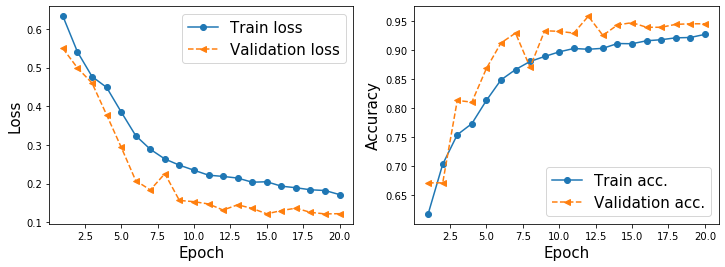

In [16]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.savefig('images/15_18.png', dpi=300)
plt.show()

In [17]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 94.63%


In [18]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1703 - accuracy: 0.9276 - val_loss: 0.1170 - val_accuracy: 0.9570
Epoch 22/30
500/500 [==============================] - 8s 15ms/step - loss: 0.1665 - accuracy: 0.9263 - val_loss: 0.1427 - val_accuracy: 0.9200
Epoch 23/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1611 - accuracy: 0.9312 - val_loss: 0.1036 - val_accuracy: 0.9650
Epoch 24/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1609 - accuracy: 0.9304 - val_loss: 0.1421 - val_accuracy: 0.9260
Epoch 25/30
500/500 [==============================] - 8s 15ms/step - loss: 0.1593 - accuracy: 0.9335 - val_loss: 0.1043 - val_accuracy: 0.9610
Epoch 26/30
500/500 [==============================] - 8s 15ms/step - loss: 0.1567 - accuracy: 0.9326 - val_loss: 0.1168 - val_accuracy: 0.9570
Epoch 27/30
500/500 [==============================] - 8s 15ms/step - loss: 0.1513 - accuracy: 0.9344 - val_loss: 0.0991 - val_accuracy:

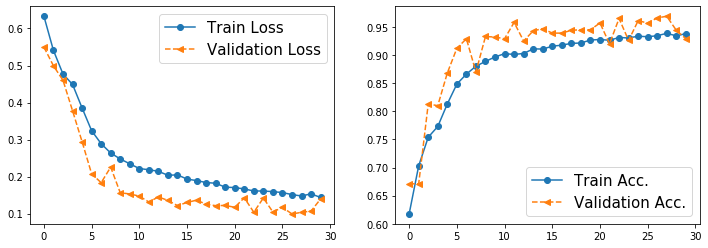

In [19]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'], 
        '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'],
        '--<', label='Validation Loss')
ax.legend(fontsize=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'], 
        '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'], 
        '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [20]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('테스트 정확도: {:.2f}%'.format(results[1]*100))

테스트 정확도: 93.72%


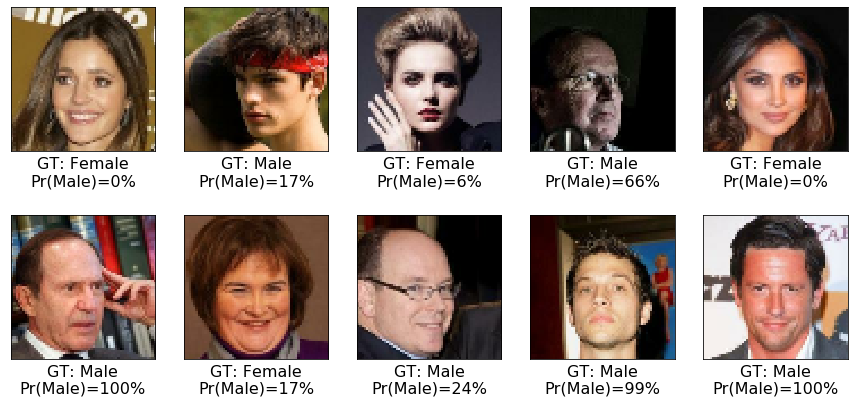

In [21]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.savefig('images/15_19.png', dpi=300)
plt.show()

In [22]:
model.save('models/celeba-cnn.h5')

...


## Summary

...



## Appendix:

### The effect of initial shuffling

In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
#datasets = tfds.load(name='mnist')
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare(download_dir='~/github/tensorflow_datasets/downloads')
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with using Builder and specifying `mnist_bldr.as_dataset(shuffle_files=False)`**

In [24]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('레이블 개수:', count_labels(mnist_valid))
print('레이블 개수:', count_labels(mnist_valid))

레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})


In [25]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
datasets = tfds.load(name='mnist')
#mnist_bldr = tfds.builder('mnist')
#mnist_bldr.download_and_prepare()
#datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with `tfds.load()`**

In [26]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('레이블 개수:', count_labels(mnist_valid))
print('레이블 개수:', count_labels(mnist_valid))

레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
레이블 개수: Counter({7: 19, 9: 14, 6: 13, 5: 11, 4: 11, 0: 8, 2: 7, 3: 7, 1: 5, 8: 5})
